# Examples of Time-Homogeneous Markov Chains

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import random

## Example 1

Let's look at a simple three state Markov chian where the states $\mathcal{S} = \{1,2,3\}$ and the transition probabilities are described in the table:

|           | $X_1 = 1$ | $X_1 = 2$ | $X_1 = 3$ |
|-----------|-----------|-----------|-----------|
| $X_0 = 1$ | $1/3$     | $1/6$     | $1/2$     |
| $X_0 = 2$ | $1/2$     | $0$       | $1/2$     |
| $X_0 = 3$ | $1/4$     | $1/4$     | $1/2$     |

We can write this as a matrix, which is below:
$$
P = \begin{bmatrix}
1/3 & 1/6& 1/2\\
1/2 & 0 & 1/2\\
1/4& 1/4 & 1/2
\end{bmatrix}.
$$

Putting this into python code we get (and I will round everything to two decimal places):

In [15]:
P = np.array([[1/3, 1/6, 1/2], [1/2,0,1/2], [1/4,1/4,1/2]])
print(np.round(P,2))

[[0.33 0.17 0.5 ]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.5 ]]


Recall that the *stationary distribution* $\boldsymbol{\pi} = (\pi_1,\pi_2,\pi_3)$ is a row vector such that $\boldsymbol{\pi} P = \boldsymbol{\pi}$.

We can use ``scipy.linalg.eig`` to compute left eigenvectors.


In [23]:
w, vl, vr = scipy.linalg.eig(P, left = True)
print(np.round(np.real(w),2))
print(np.round(vl,2))

[ 1.   -0.   -0.17]
[[-0.52 -0.8   0.71]
 [-0.29  0.27 -0.71]
 [-0.81  0.53 -0.  ]]


We can check that the first column of the $3\times 3$ matrix above cooresponds to a left eigenvector of eigenvalue 1:

In [24]:
np.round(np.matmul(vl[:,0],P),2)

array([-0.52, -0.29, -0.81])

That means that the vector $\mathbf{v} \approx (-0.52, -0.29, -0.81)$ is actually proportional to the stationary distribution $\boldsymbol{\pi}$. The ``scipy.linalg.eig`` returns a length $1$ vector ($\|\mathbf{v}\|_2^2 = \sum_{i} v_i^2 = 1$) but we want the vector $\boldsymbol{\pi}$ to satisfy $\sum_{i} \pi_i = 1$.

In [25]:
np.linalg.norm(vl[:,0])

1.0

So we will now transform the vector $\boldsymbol{v}$ to the actual stationary distribution:
$$\pi_i = \frac{v_i}{\sum_j v_j}. $$

In [26]:
piVec = vl[:,0]/np.sum(vl[:,0])
print(np.round(piVec,2))

[0.32 0.18 0.5 ]


This looks close to the rational vector $ (1/3, 1/6, 1/2)$ so maybe there was a rounding error. Let's check by hand:
$$
\begin{bmatrix}
1/3&1/6&1/2
\end{bmatrix}\begin{bmatrix}
1/3&1/6&1/2\\
1/2&0&1/2\\
1/4&1/4&1/2
\end{bmatrix} = \begin{bmatrix}
\frac13\frac13 + \frac16\frac12 + \frac12\frac14 & \frac13\frac16 + \frac16 0 + \frac12\frac14 & \frac13\frac12 + \frac16\frac12 & \frac12\frac12
\end{bmatrix}
$$
$$
= \begin{bmatrix}
\frac{1}{9}+\frac{1}{12}+ \frac{1}{8} & \frac{1}{18} + \frac{1}{8} & \frac{1}{6}+\frac{1}{12} + \frac{1}{4}
\end{bmatrix}
$$
$$
= \begin{bmatrix}
\frac{23}{72} & \frac{13}{72} & \frac{1}{2}
\end{bmatrix}.
$$
That means that the stationary distribution $\boldsymbol{\pi}\neq (1/3,1/6,1/2)$.


Let's run a few experiments.

We'll write the code more generally:

In [20]:
def runMarkovChain(startPosition, transMat, steps):
    n = np.shape(transMat)[0] # Number of states
    Xpath = [startPosition]
    for t in range(steps):
        x = Xpath[-1]
        y = random.choices([j for j in range(n)], weights= [a for a in transMat[x,:]],k=1)[0]
        Xpath.append(y)
    return Xpath

Now let's run this to get the outcomes of a large number of trials (say 200) after 1000 steps where all are started from the position 0.

In [21]:
X = []
trials = 200
steps = 1000
for outcome in range(trials):
    Xpath = runMarkovChain(0, P, steps)
    X.append(Xpath[-1])

Let's look at the empirical histogram of $X$ and see if it is close to the stationary distribution?

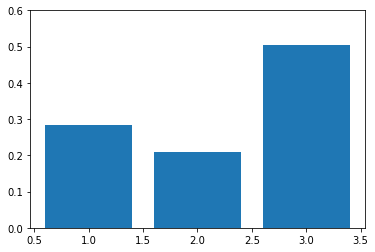

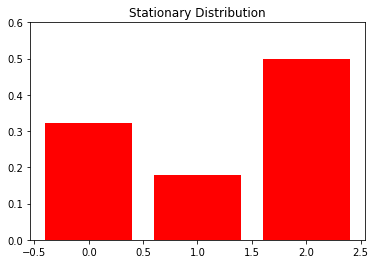

In [29]:
plt.bar( [1,2,3],[np.sum([r == j for r in X])/trials for j in range(3)])
plt.ylim(0,.6)
plt.show()
plt.bar( [j for j in range(3)],piVec, color = 'r')
plt.title("Stationary Distribution")
plt.ylim(0,.6)
plt.show()

## Example 2

Let's try a much larger example. 

We will have states $\mathcal{S} = \{0,1,2,\dotsm, 5\}$ and the transition probabilities are as follows:
$$
\mathbb{P}(X_1 = k | X_0 = n) = \begin{cases}
\displaystyle \binom{n}{k} \left(\frac{2}{3}\right)^k \left(\frac{1}{3} \right)^{n-k} &: n>0\text{ and } k = 0,1,\dotsm, n\\
0 &: n>0, k>n \text{ or }k \neq 5 \text{ and }n = 0\\
1&: n = 0, k = 5
\end{cases}.
$$

In words what this does is the following: If you are at state $n = 0$, then your next state is $k =5$. However, if you are at state $n\neq 0$, then your next state is randomly distributed according to a binomial random variable with parameters $n$ and $p = 2/3$.

In [10]:
def genBinPMF(n,p,totalLength): #this just generates the pmf of a Binomial
    pVec = [np.math.comb(n,k)* p**(k) *(1-p)**(n-k) for k in range(n+1)]
    pVec.extend([0 for j in range(totalLength-n)])
    return pVec

Prows = [[0,0,0,0,0,1]]
Prows.extend([genBinPMF(n,2/3,5) for n in range(1,6)])
P = np.stack(Prows, axis = 0)
print(np.round(P,2))

[[0.   0.   0.   0.   0.   1.  ]
 [0.33 0.67 0.   0.   0.   0.  ]
 [0.11 0.44 0.44 0.   0.   0.  ]
 [0.04 0.22 0.44 0.3  0.   0.  ]
 [0.01 0.1  0.3  0.4  0.2  0.  ]
 [0.   0.04 0.16 0.33 0.33 0.13]]


Let's get the stationary distribution:

In [11]:
def GetStationVec(transMat):
    w, vl, vr = scipy.linalg.eig(transMat, left = True)
    pi = np.array(np.real(vl[:,0]))
    pi = pi/np.sum(pi)
    return pi
pi = GetStationVec(P)
print(np.round(pi,2))

[0.14 0.35 0.17 0.11 0.07 0.16]


Let's also run a lot of trials and compare this to the true stationary distribution. Again, we'll start from the state 0.

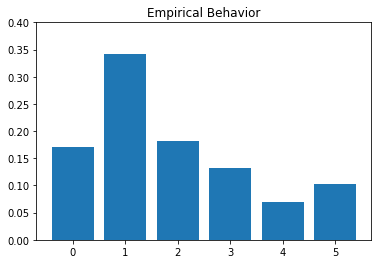

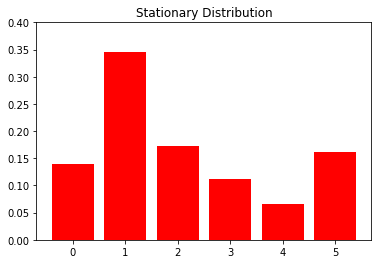

In [12]:
X = []
trials = 400
steps = 1000
for outcome in range(trials):
    Xpath = runMarkovChain(0, P, steps)
    X.append(Xpath[-1])
plt.bar( [j for j in range(6)],[np.sum([r == j for r in X])/trials for j in range(6)])
plt.ylim(0,.4)
plt.title("Empirical Behavior")
plt.show()
plt.bar( [j for j in range(6)],pi, color = 'r')
plt.title("Stationary Distribution")
plt.ylim(0,.4)
plt.show()

The two distributions look almost exactly the same. 